In [1]:
import xarray as xr
import numpy as np
import xrft
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from glob import glob
from pyresample.bilinear import NumpyBilinearResampler
from pyresample import geometry
from matplotlib.colors import LogNorm


In [2]:
ds = xr.open_zarr('/swot/SUM02/spencer/daily_filt/two_weeks.zarr')

In [3]:
ds=ds.drop_vars('time')
ds['time']=ds['time']*3600

In [4]:
f = 2*2*np.pi/24/3600*np.sin(ds.y0*np.pi/180)

In [5]:
def lanczos(x, a):
    return np.sinc(x/a)
def sinc2(x, a):
    return np.sinc(x/a)

window_width=72
weight = xr.DataArray(sinc2(np.expand_dims(np.arange(-window_width/2,window_width/2),1),np.expand_dims(np.pi/f.values/3600*1.1,0)), dims=['window','j'])
#weight = xr.DataArray(sinc2(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])
nofiles=168
u_eul_filtered = ds.unfiltered_u.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
v_eul_filtered = ds.unfiltered_v.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
ssh_eul_filtered = ds.unfiltered_steric_ssh.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight,dims='window')/weight.sum('window')
u_eul_filtered = u_eul_filtered.isel(time=slice(44,44+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
v_eul_filtered = v_eul_filtered.isel(time=slice(44,44+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
ssh_eul_filtered = ssh_eul_filtered.isel(time=slice(44,44+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})

In [6]:
u_lag_filtered = ds.lagfiltered_u.isel(time=slice(44,44+nofiles))
v_lag_filtered = ds.lagfiltered_v.isel(time=slice(44,44+nofiles))
ssh_lag_filtered = ds.lagfiltered_ssh.isel(time=slice(44,44+nofiles))

u_unfiltered = ds.unfiltered_u.isel(time=slice(44,44+nofiles))
v_unfiltered = ds.unfiltered_v.isel(time=slice(44,44+nofiles))
ssh_unfiltered = ds.unfiltered_steric_ssh.isel(time=slice(44,44+nofiles))

In [7]:
u_eul_filtered = u_eul_filtered.assign_coords(x0=("i", ds.x0.values)).swap_dims({"i": "x0"})
u_eul_filtered = u_eul_filtered.assign_coords(y0=("j", ds.y0.values)).swap_dims({"j": "y0"})
v_eul_filtered = v_eul_filtered.assign_coords(x0=("i", ds.x0.values)).swap_dims({"i": "x0"})
v_eul_filtered = v_eul_filtered.assign_coords(y0=("j", ds.y0.values)).swap_dims({"j": "y0"})
ssh_eul_filtered = ssh_eul_filtered.assign_coords(x0=("i", ds.x0.values)).swap_dims({"i": "x0"})
ssh_eul_filtered = ssh_eul_filtered.assign_coords(y0=("j", ds.y0.values)).swap_dims({"j": "y0"})
u_lag_filtered = u_lag_filtered.swap_dims({"i": "x0"})
u_lag_filtered = u_lag_filtered.swap_dims({"j": "y0"})
v_lag_filtered = v_lag_filtered.swap_dims({"i": "x0"})
v_lag_filtered = v_lag_filtered.swap_dims({"j": "y0"})
u_unfiltered = u_unfiltered.swap_dims({"i": "x0"})
u_unfiltered = u_unfiltered.swap_dims({"j": "y0"})
v_unfiltered = v_unfiltered.swap_dims({"i": "x0"})
v_unfiltered = v_unfiltered.swap_dims({"j": "y0"})

ssh_lag_filtered = ssh_lag_filtered.swap_dims({"i": "x0"})
ssh_lag_filtered = ssh_lag_filtered.swap_dims({"j": "y0"})
ssh_unfiltered = ssh_unfiltered.swap_dims({"i": "x0"})
ssh_unfiltered = ssh_unfiltered.swap_dims({"j": "y0"})

In [8]:
xmina=900#region c:+500
xmaxa=-900#region c:+500

ymina=900#region c: +250
ymaxa=-900#region c: +250
lonsa, latsa = np.meshgrid(u_eul_filtered.x0.isel(x0=slice(xmina,xmaxa)).values, u_eul_filtered.y0.isel(y0=slice(ymina,ymaxa)).values)

xminb=900+500#region c:+500
xmaxb=-900+500#region c:+500

yminb=900+250#region c: +250
ymaxb=-900+250#region c: +250
lonsb, latsb = np.meshgrid(u_eul_filtered.x0.isel(x0=slice(xminb,xmaxb)).values, u_eul_filtered.y0.isel(y0=slice(yminb,ymaxb)).values)

In [9]:
def target_area_def_a(ds_patch,variable_name):
    """Get a pyresample area_def for a given patch."""
    center_point = ds_patch.isel(x0=ds_patch.x0.size//2, y0=ds_patch.y0.size//2)
    center_lon, center_lat =center_point.x0.values.item(),-center_point.y0.values.item()#region b:3,32 # region c: 17,40
    #region a: center_point.x0.values.item(),-center_point.y0.values.item()
    area_id = 'local_grid'
    description = 'Local Lambert Equal Area Grid'
    proj_id = 'local_grid'
    proj_dict = {'proj': 'laea', 'lon_0': center_lon, 'lat_0': center_lat,'units': 'm'} #  'a': 6371228.0,

    # 1 km resolution
    width = 512#2160
    height = 512#2160

    # 512 x 512 km
    area_extent = (-270000., -270000., 270000., 270000.)
    area_def = geometry.AreaDefinition(area_id, description, proj_id, proj_dict,
                                       width, height, area_extent)
    return area_def

def target_area_def_b(ds_patch,variable_name):
    """Get a pyresample area_def for a given patch."""
    center_point = ds_patch.isel(x0=ds_patch.x0.size//2, y0=ds_patch.y0.size//2)
    center_lon, center_lat =17,40#center_point.x0.values.item(),-center_point.y0.values.item()#region b:3,32 # region c: 17,40
    #region a: center_point.x0.values.item(),-center_point.y0.values.item()
    area_id = 'local_grid'
    description = 'Local Lambert Equal Area Grid'
    proj_id = 'local_grid'
    proj_dict = {'proj': 'laea', 'lon_0': center_lon, 'lat_0': center_lat,'units': 'm'} #  'a': 6371228.0,

    # 1 km resolution
    width = 512#2160
    height = 512#2160

    # 512 x 512 km
    area_extent = (-270000., -270000., 270000., 270000.)
    area_def = geometry.AreaDefinition(area_id, description, proj_id, proj_dict,
                                       width, height, area_extent)
    return area_def



def resample_transposed(data, resampler):
    return np.transpose(resampler.resample(data), (2, 0, 1))

def ufunc_resample_a(data):
    target_def = target_area_def_a(data.isel(time=0),'U')
    source_def = geometry.SwathDefinition(lons=lonsa, lats=-latsa)
    resampler = NumpyBilinearResampler(source_def, target_def, 30e3)
    resampled = xr.apply_ufunc(resample_transposed,data,resampler,input_core_dims=[['y0','x0'],['y0','x0']],output_core_dims=[['y1','x1']])
    return resampled

def ufunc_resample_b(data):
    target_def = target_area_def_b(data.isel(time=0),'U')
    source_def = geometry.SwathDefinition(lons=lonsb, lats=-latsb)
    resampler = NumpyBilinearResampler(source_def, target_def, 30e3)
    resampled = xr.apply_ufunc(resample_transposed,data,resampler,input_core_dims=[['y0','x0'],['y0','x0']],output_core_dims=[['y1','x1']])
    return resampled

In [10]:
x_resampleda = ufunc_resample_a((u_eul_filtered.x0.isel(x0=slice(xmina,xmaxa))*xr.ones_like(u_eul_filtered.isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).isel(time=slice(0,10)))).load().T)
y_resampleda = ufunc_resample_a((u_eul_filtered.y0.isel(y0=slice(ymina,ymaxa))*xr.ones_like(u_eul_filtered.isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).isel(time=slice(0,10)))).load().T)

x_resampledb = ufunc_resample_b((u_eul_filtered.x0.isel(x0=slice(xminb,xmaxb))*xr.ones_like(u_eul_filtered.isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).isel(time=slice(0,10)))).load().T)
y_resampledb = ufunc_resample_b((u_eul_filtered.y0.isel(y0=slice(yminb,ymaxb))*xr.ones_like(u_eul_filtered.isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).isel(time=slice(0,10)))).load().T)

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = se

In [11]:
u_eul_resampleda = ufunc_resample_a(u_eul_filtered.isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).load())
v_eul_resampleda = ufunc_resample_a(v_eul_filtered.isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).load())
u_resampleda = ufunc_resample_a(u_lag_filtered.isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).load())
v_resampleda = ufunc_resample_a(v_lag_filtered.isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).load())
u_resampled_unfilta = ufunc_resample_a(u_unfiltered.isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).load())
v_resampled_unfilta = ufunc_resample_a(v_unfiltered.isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).load())

eta_resampled_unfilta = ufunc_resample_a(ssh_unfiltered.isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).load())
eta_resampleda = ufunc_resample_a(ssh_lag_filtered.isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).load())
eta_eul_resampleda = ufunc_resample_a(ssh_eul_filtered.isel(x0=slice(xmina,xmaxa),y0=slice(ymina,ymaxa)).load())


u_eul_resampledb = ufunc_resample_b(u_eul_filtered.isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).load())
v_eul_resampledb = ufunc_resample_b(v_eul_filtered.isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).load())
u_resampledb = ufunc_resample_b(u_lag_filtered.isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).load())
v_resampledb = ufunc_resample_b(v_lag_filtered.isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).load())
u_resampled_unfiltb = ufunc_resample_b(u_unfiltered.isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).load())
v_resampled_unfiltb = ufunc_resample_b(v_unfiltered.isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).load())

eta_resampled_unfiltb = ufunc_resample_b(ssh_unfiltered.isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).load())
eta_resampledb = ufunc_resample_b(ssh_lag_filtered.isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).load())
eta_eul_resampledb = ufunc_resample_b(ssh_eul_filtered.isel(x0=slice(xminb,xmaxb),y0=slice(yminb,ymaxb)).load())

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = se

In [12]:
u_eul_resampleda = u_eul_resampleda.assign_coords(x1=("x1", u_eul_resampleda.x1.values)).assign_coords(y1=("y1", u_eul_resampleda.y1.values))
v_eul_resampleda = v_eul_resampleda.assign_coords(x1=("x1", v_eul_resampleda.x1.values)).assign_coords(y1=("y1", v_eul_resampleda.y1.values))
eta_eul_resampleda = eta_eul_resampleda.assign_coords(x1=("x1", v_eul_resampleda.x1.values)).assign_coords(y1=("y1", v_eul_resampleda.y1.values))
u_resampleda = u_resampleda.assign_coords(x1=("x1", u_resampleda.x1.values)).assign_coords(y1=("y1", u_resampleda.y1.values))
v_resampleda = v_resampleda.assign_coords(x1=("x1", v_resampleda.x1.values)).assign_coords(y1=("y1", v_resampleda.y1.values))
eta_resampleda = eta_resampleda.assign_coords(x1=("x1", v_resampleda.x1.values)).assign_coords(y1=("y1", v_resampleda.y1.values))
u_resampled_unfilta = u_resampled_unfilta.assign_coords(x1=("x1", u_resampled_unfilta.x1.values)).assign_coords(y1=("y1", u_resampled_unfilta.y1.values))
v_resampled_unfilta = v_resampled_unfilta.assign_coords(x1=("x1", v_resampled_unfilta.x1.values)).assign_coords(y1=("y1", v_resampled_unfilta.y1.values))
eta_resampled_unfilta = eta_resampled_unfilta.assign_coords(x1=("x1", v_resampled_unfilta.x1.values)).assign_coords(y1=("y1", v_resampled_unfilta.y1.values))

u_eul_resampledb = u_eul_resampledb.assign_coords(x1=("x1", u_eul_resampledb.x1.values)).assign_coords(y1=("y1", u_eul_resampledb.y1.values))
v_eul_resampledb = v_eul_resampledb.assign_coords(x1=("x1", v_eul_resampledb.x1.values)).assign_coords(y1=("y1", v_eul_resampledb.y1.values))
eta_eul_resampledb = eta_eul_resampledb.assign_coords(x1=("x1", eta_eul_resampledb.x1.values)).assign_coords(y1=("y1", eta_eul_resampledb.y1.values))
u_resampledb = u_resampledb.assign_coords(x1=("x1", u_resampledb.x1.values)).assign_coords(y1=("y1", u_resampledb.y1.values))
v_resampledb = v_resampledb.assign_coords(x1=("x1", v_resampledb.x1.values)).assign_coords(y1=("y1", v_resampledb.y1.values))
eta_resampledb = eta_resampledb.assign_coords(x1=("x1", eta_resampledb.x1.values)).assign_coords(y1=("y1", eta_resampledb.y1.values))
u_resampled_unfiltb = u_resampled_unfiltb.assign_coords(x1=("x1", u_resampled_unfiltb.x1.values)).assign_coords(y1=("y1", u_resampled_unfiltb.y1.values))
v_resampled_unfiltb = v_resampled_unfiltb.assign_coords(x1=("x1", v_resampled_unfiltb.x1.values)).assign_coords(y1=("y1", v_resampled_unfiltb.y1.values))
eta_resampled_unfiltb = eta_resampled_unfiltb.assign_coords(x1=("x1", eta_resampled_unfiltb.x1.values)).assign_coords(y1=("y1", eta_resampled_unfiltb.y1.values))

In [13]:
with ProgressBar():
    u2_psa = xrft.power_spectrum(u_resampleda, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    v2_psa = xrft.power_spectrum(v_resampleda, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    eta_psa = xrft.power_spectrum(eta_resampleda, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    u2_psb = xrft.power_spectrum(u_resampledb, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    v2_psb = xrft.power_spectrum(v_resampledb, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    eta_psb = xrft.power_spectrum(eta_resampledb, dim=['x1','y1','time'],window=True,window_correction=True).compute()
vel_psa = (u2_psa + v2_psa)*0.5
vel_psb = (u2_psb + v2_psb)*0.5

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7

In [14]:
with ProgressBar():
    u2_ps_unfilta = xrft.power_spectrum(u_resampled_unfilta, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    v2_ps_unfilta = xrft.power_spectrum(v_resampled_unfilta, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    eta_ps_unfilta = xrft.power_spectrum(eta_resampled_unfilta, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    u2_ps_unfiltb = xrft.power_spectrum(u_resampled_unfiltb, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    v2_ps_unfiltb = xrft.power_spectrum(v_resampled_unfiltb, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    eta_ps_unfiltb = xrft.power_spectrum(eta_resampled_unfiltb, dim=['x1','y1','time'],window=True,window_correction=True).compute()
vel_ps_unfilta = (u2_ps_unfilta + v2_ps_unfilta)*0.5
vel_ps_unfiltb = (u2_ps_unfiltb + v2_ps_unfiltb)*0.5

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7

In [15]:
with ProgressBar():
    u2_ps_eula = xrft.power_spectrum(u_eul_resampleda, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    v2_ps_eula = xrft.power_spectrum(v_eul_resampleda, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    eta_ps_eula = xrft.power_spectrum(eta_eul_resampleda, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    u2_ps_eulb = xrft.power_spectrum(u_eul_resampledb, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    v2_ps_eulb = xrft.power_spectrum(v_eul_resampledb, dim=['x1','y1','time'],window=True,window_correction=True).compute()
    eta_ps_eulb = xrft.power_spectrum(eta_eul_resampledb, dim=['x1','y1','time'],window=True,window_correction=True).compute()
vel_ps_eula = (u2_ps_eula + v2_ps_eula)*0.5
vel_ps_eulb = (u2_ps_eulb + v2_ps_eulb)*0.5

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7

In [16]:
v_eul_resampledb.isel(time=150)

<xarray.DataArray (y1: 512, x1: 512)>
array([[ 3.23851449e-02,  4.14040672e-02,  5.24595303e-02, ...,
         1.52881847e-01,  1.73311567e-01,  1.92557564e-01],
       [ 2.72124504e-02,  3.78445511e-02,  5.29692696e-02, ...,
         1.45159210e-01,  1.66099695e-01,  1.87195997e-01],
       [ 2.54990157e-02,  3.70048659e-02,  5.13951167e-02, ...,
         1.37047632e-01,  1.58761730e-01,  1.80174255e-01],
       ...,
       [-1.47715777e-01, -1.83879437e-01, -2.15650604e-01, ...,
         2.56368574e-02,  1.44433447e-02,  1.02822780e-04],
       [-1.31302183e-01, -1.68376075e-01, -2.00193341e-01, ...,
         6.94332070e-02,  6.21804768e-02,  4.91197076e-02],
       [-1.16600650e-01, -1.54338483e-01, -1.86077631e-01, ...,
         1.08372269e-01,  1.06732373e-01,  9.84658802e-02]])
Coordinates:
    face     int64 1
    k        int64 0
    niter    int64 0
    z0       float64 -0.5
    time     int64 540000
  * x1       (x1) int64 0 1 2 3 4 5 6 7 8 ... 504 505 506 507 508 509 510 511
  * y1       (y1) int64 0 1 2 3 4 5 6 7 8 ... 504 505 506 507 508 509 510 511

In [17]:
#for torres filter, we should actually compute the fourier transform first
fm = 2*2*np.pi/24/3600*np.sin(-43*np.pi/180)
with ProgressBar():
    u2_xs_unfilta = xrft.dft(u_resampled_unfilta.drop_vars('time'), dim=['x1','y1','time'],window=True).compute()#,window=True,window_correction=True
    v2_xs_unfilta = xrft.dft(v_resampled_unfilta.drop_vars('time'), dim=['x1','y1','time'],window=True).compute()
    u2_xs_unfiltb = xrft.dft(u_resampled_unfiltb.drop_vars('time'), dim=['x1','y1','time'],window=True).compute()#,window=True,window_correction=True
    v2_xs_unfiltb = xrft.dft(v_resampled_unfiltb.drop_vars('time'), dim=['x1','y1','time'],window=True).compute()
kx = v2_xs_unfilta.freq_x1
ky = v2_xs_unfilta.freq_y1
kr = np.sqrt(kx**2+ky**2)
omegaM = np.nan*np.ones([kr.shape[0], kr.shape[1], 11])
for i in range(1,11):
    Kdi = 1/ds.Rossby_radius[i]
    omegaM[:,:,i] = (fm**2*(1+ (kr/1000*4*np.pi)**2/Kdi**2).values)**0.5*3600
u2_xs_tofilta = u2_xs_unfilta.where(np.abs(u2_xs_unfilta.freq_time)*xr.ones_like(u2_xs_unfilta)<omegaM[:,:,10]/np.pi/2)
v2_xs_tofilta = v2_xs_unfilta.where(np.abs(v2_xs_unfilta.freq_time)*xr.ones_like(v2_xs_unfilta)<omegaM[:,:,10]/np.pi/2)
u2_xs_tofiltb = u2_xs_unfiltb.where(np.abs(u2_xs_unfiltb.freq_time)*xr.ones_like(u2_xs_unfiltb)<omegaM[:,:,10]/np.pi/2)
v2_xs_tofiltb = v2_xs_unfiltb.where(np.abs(v2_xs_unfiltb.freq_time)*xr.ones_like(v2_xs_unfiltb)<omegaM[:,:,10]/np.pi/2)
windows,_ = xrft.xrft._apply_window(u_eul_resampleda, dims=['x1','y1','time'])
vel_ps_eul_torresa = (np.abs(u2_xs_tofilta)**2 + np.abs(v2_xs_tofilta)**2)*0.5/(windows**2).mean()/5825.42222222
vel_ps_eul_torresb = (np.abs(u2_xs_tofiltb)**2 + np.abs(v2_xs_tofiltb)**2)*0.5/(windows**2).mean()/5825.42222222

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:336: FutureWarning: Flags true_phase and true_amplitude will be set to True in future versions of xrft.dft to preserve the theoretical phasing and amplitude of Fourier Transform. Consider using xrft.fft to ensure future compatibility with numpy.fft like behavior and to deactivate this warning.
  warnings.warn(msg, FutureWarning)
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,


In [18]:
# Add the isotropic calculation (k,l) -> (k_r) (azimuthally average)
def azimuthal_avg(k, l, f, N, nfactor):
    """
    Takes the azimuthal average of a given field.
    """
    k = k.values; l = l.values
    kk, ll = np.meshgrid(k, l)
    K = np.sqrt(kk**2 + ll**2)
    nbins = int(N/nfactor)
    if k.max() > l.max():
        ki = np.linspace(0., l.max(), nbins)
    else:
        ki = np.linspace(0., k.max(), nbins)

    kidx = np.digitize(np.ravel(K), ki)
    area = np.bincount(kidx)

    kr = np.bincount(kidx, weights=K.ravel()) / area

    if f.ndim == 2:
        iso_f = np.ma.masked_invalid(np.bincount(kidx,
                                    weights=f.data.ravel())
                                    / area) * kr
    else:
        raise ValueError('The data has too many or few dimensions. '
                        'The input should only have the two dimensions '
                        'to take the azimuthal averaging over.')

    return kr, iso_f

def iso_spec_over_depth(ds):
    
    Zlen = len(ds.Z)
    klen = len(ds.freq_XC)
    omegalen = len(ds.freq_time)
    
    nfactor = 4. 
    ds_iso = np.zeros([omegalen , Zlen, int(klen/nfactor+1)])

    for j in range(0,omegalen):
        for i in range(0,Zlen):
            kr, ds_iso[j,i,:] = azimuthal_avg(ds.freq_XC, ds.freq_YC, ds.isel(Z=i, freq_time=j), 
                            len(ds.freq_XC), nfactor)
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'freq_time':ds.freq_time.values, 'Z': ds.Z.values, 'kr':kr }, 
                             dims=['freq_time','Z', 'kr'])
    
    return ds_iso_xr

def iso_spec(ds):
    
    #Zlen = len(ds.Z)
    klen = len(ds.freq_x1)
    omegalen = len(ds.freq_time)
    
    nfactor = 4. 
    ds_iso = np.zeros([omegalen ,  int(klen/nfactor+1)])

    for j in range(0,omegalen):
            kr, ds_iso[j,:] = azimuthal_avg(ds.freq_x1, ds.freq_y1, ds.isel(freq_time=j), 
                            len(ds.freq_x1), nfactor)
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'freq_time':ds.freq_time.values, 'kr':kr }, 
                             dims=['freq_time','kr'])
    
    return ds_iso_xr

In [19]:
ps_isoa = iso_spec(vel_psa)
ps_iso_unfilta = iso_spec(vel_ps_unfilta)
ps_iso_eula = iso_spec(vel_ps_eula)
ps_iso_torresa = iso_spec(vel_ps_eul_torresa)
eta_isoa = iso_spec(eta_psa)
eta_iso_unfilta = iso_spec(eta_ps_unfilta)
eta_iso_eula = iso_spec(eta_ps_eula)

ps_isob = iso_spec(vel_psb)
ps_iso_unfiltb = iso_spec(vel_ps_unfiltb)
ps_iso_eulb = iso_spec(vel_ps_eulb)
ps_iso_torresb = iso_spec(vel_ps_eul_torresb)
eta_isob = iso_spec(eta_psb)
eta_iso_unfiltb = iso_spec(eta_ps_unfiltb)
eta_iso_eulb = iso_spec(eta_ps_eulb)

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide


In [20]:
vel_ps_eulb

<xarray.DataArray (freq_time: 168, freq_y1: 512, freq_x1: 512)>
array([[[2.50989339e-08, 2.28188540e-08, 1.37039499e-08, ...,
         5.43676526e-09, 1.37039499e-08, 2.28188540e-08],
        [6.76916255e-09, 9.52677513e-09, 6.51063537e-09, ...,
         1.23806956e-08, 8.00805200e-09, 4.70677892e-09],
        [1.03299488e-08, 1.73769128e-08, 2.09074155e-08, ...,
         1.20462616e-09, 1.05939654e-09, 3.53767688e-09],
        ...,
        [5.22882149e-09, 3.84278444e-09, 6.96085863e-09, ...,
         5.27834913e-09, 8.02501093e-09, 1.08470092e-08],
        [1.03299488e-08, 3.53767688e-09, 1.05939654e-09, ...,
         2.25283745e-08, 2.09074155e-08, 1.73769128e-08],
        [6.76916255e-09, 4.70677892e-09, 8.00805200e-09, ...,
         9.68390212e-09, 6.51063537e-09, 9.52677513e-09]],

       [[1.46331849e-08, 9.39407433e-09, 1.08776275e-08, ...,
         9.90148356e-09, 2.03077366e-08, 2.29873741e-08],
        [6.35260906e-09, 6.74456127e-09, 3.72053501e-09, ...,
         1.04867814e-08, 6.27676715e-09, 6.73383510e-09],
        [1.79918997e-08, 8.76466547e-09, 1.20631449e-08, ...,
         1.82155851e-09, 9.57489255e-09, 2.18631273e-08],
...
        [1.43753095e-08, 9.26634819e-09, 7.98559764e-09, ...,
         2.35856673e-09, 2.18190480e-09, 1.01470596e-08],
        [7.94853512e-09, 1.36677272e-08, 1.35345166e-08, ...,
         5.70863927e-09, 7.88699442e-09, 4.26094413e-09],
        [7.45823596e-09, 1.04735858e-08, 7.26297852e-09, ...,
         7.72140495e-10, 2.55511156e-09, 2.40645723e-09]],

       [[1.46331849e-08, 2.29873741e-08, 2.03077366e-08, ...,
         8.28813123e-09, 1.08776275e-08, 9.39407433e-09],
        [3.45507084e-09, 3.92470880e-09, 2.91851789e-09, ...,
         1.32928314e-08, 1.06975736e-08, 2.91778641e-09],
        [5.05858522e-09, 1.63124303e-08, 1.68287493e-08, ...,
         5.62317988e-09, 3.12024034e-09, 7.69110899e-10],
        ...,
        [1.31881179e-08, 9.64205614e-09, 1.05544633e-08, ...,
         2.66260549e-09, 3.41812485e-09, 1.19846077e-08],
        [1.79918997e-08, 2.18631273e-08, 9.57489255e-09, ...,
         1.46903738e-08, 1.20631449e-08, 8.76466547e-09],
        [6.35260906e-09, 6.73383510e-09, 6.27676715e-09, ...,
         5.47083501e-09, 3.72053501e-09, 6.74456127e-09]]])
Coordinates:
    face       int64 1
    k          int64 0
    niter      int64 0
    z0         float64 -0.5
  * freq_x1    (freq_x1) float64 -0.5 -0.498 -0.4961 ... 0.4941 0.4961 0.498
  * freq_y1    (freq_y1) float64 -0.5 -0.498 -0.4961 ... 0.4941 0.4961 0.498
  * freq_time  (freq_time) float64 -0.0001389 -0.0001372 ... 0.0001356 0.0001372

In [21]:
kr    = ps_isoa.kr
omegaM = np.nan*np.ones([kr.shape[0], 11])
for i in range(1,11):
    
    Kdi = 1/ds.Rossby_radius[i]
    omegaM[:,i] = (fm**2*(1+ (kr/1000*4*np.pi)**2/Kdi**2).values)**0.5*3600

In [22]:
omegaM[:,10]

array([0.35709351, 0.35732219, 0.3582778 , 0.36023591, 0.36312588,
       0.36706116, 0.37202358, 0.37771908, 0.3841677 , 0.39165095,
       0.3998557 , 0.40856983, 0.41818423, 0.42836186, 0.43889646,
       0.45024679, 0.46206194, 0.47428537, 0.4871244 , 0.50002961,
       0.51310029, 0.52683015, 0.54102378, 0.55557836, 0.57025661,
       0.58475951, 0.59987074, 0.61542285, 0.63067221, 0.64627482,
       0.66240231, 0.67845241, 0.69423699, 0.71046714, 0.72712297,
       0.74381527, 0.76040816, 0.77689962, 0.79352346, 0.81058163,
       0.82768091, 0.84479121, 0.86192231, 0.87913745, 0.89634812,
       0.91355885, 0.93106805, 0.94880871, 0.96625325, 0.98364747,
       1.00106931, 1.01874788, 1.03680818, 1.0547035 , 1.07232624,
       1.09008939, 1.1078995 , 1.12572134, 1.1436871 , 1.16181006,
       1.17984648, 1.19780181, 1.21589745, 1.23396365, 1.2520103 ,
       1.27018996, 1.28837579, 1.30651853, 1.32466785, 1.34283606,
       1.36099809, 1.37916948, 1.39751522, 1.41592104, 1.43415

In [23]:
ps_iso_unfilta

<xarray.DataArray (freq_time: 168, kr: 129)>
array([[           nan, 5.12703082e-03, 5.64363757e-04, ...,
        1.67090628e-04, 1.63823093e-04, 2.47296924e-05],
       [           nan, 4.19511654e-03, 5.55885159e-04, ...,
        1.48107255e-04, 1.49808913e-04, 2.28822029e-05],
       [           nan, 6.89471405e-03, 5.68286580e-04, ...,
        1.06706929e-04, 1.14864055e-04, 1.79736668e-05],
       ...,
       [           nan, 1.79646684e-02, 8.36776034e-04, ...,
        9.01093491e-05, 9.93914347e-05, 1.53560773e-05],
       [           nan, 6.89471405e-03, 5.68286580e-04, ...,
        1.06706929e-04, 1.14864055e-04, 1.79736668e-05],
       [           nan, 4.19511654e-03, 5.55885159e-04, ...,
        1.48107255e-04, 1.49808913e-04, 2.28822029e-05]])
Coordinates:
  * freq_time  (freq_time) float64 -0.0001389 -0.0001372 ... 0.0001356 0.0001372
  * kr         (kr) float64 0.0 0.002653 0.006041 ... 0.4921 0.496 0.5611

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:95: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


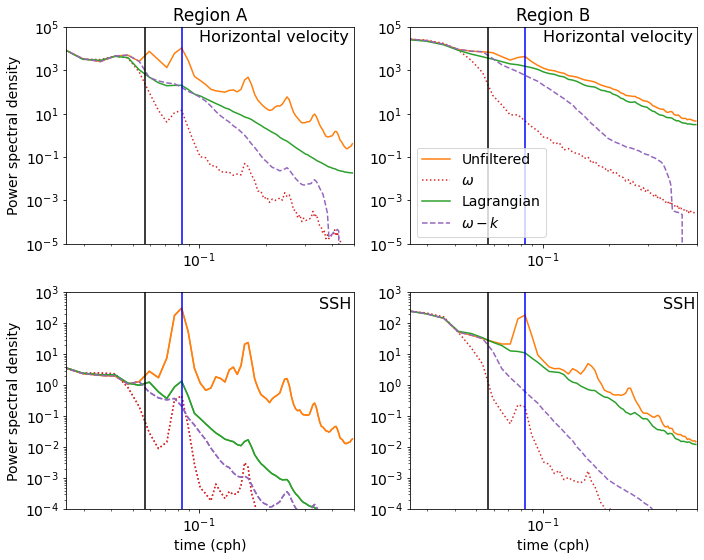

In [24]:
ps_iso_tofilta = ps_iso_unfilta
ps_iso_tofilta = ps_iso_tofilta.where(ps_iso_tofilta.freq_time*xr.ones_like(ps_iso_tofilta)*3600<omegaM[:,10]/np.pi/2)

plt.figure(figsize=(10,8))

plt.subplot(221)
ps_iso_unfilta.sum('kr').assign_coords(freq_time=ps_iso_unfilta.freq_time*3600).plot(c='tab:orange')
plt.xscale('log')
plt.yscale('log')

ps_iso_eula.sum('kr').assign_coords(freq_time=ps_iso_eula.freq_time*3600).plot(c='tab:red',linestyle =':')
plt.xscale('log')
plt.yscale('log')

ps_isoa.sum('kr').assign_coords(freq_time=ps_isoa.freq_time*3600).plot(c='tab:green')
plt.xscale('log')
plt.yscale('log')

ps_iso_tofilta.sum('kr').assign_coords(freq_time=ps_iso_tofilta.freq_time*3600).plot(c='tab:purple',linestyle ='--')
plt.xscale('log')
plt.yscale('log')

ps_iso_tofiltb = ps_iso_unfiltb
ps_iso_tofiltb = ps_iso_tofiltb.where(ps_iso_tofiltb.freq_time*xr.ones_like(ps_iso_tofiltb)*3600<omegaM[:,10]/np.pi/2)

plt.ylim(10**-5,10**5)
plt.xlim(0.025,0.5)
plt.ylabel('Power spectral density')
plt.title('Region A')

plt.text(0.1, 2*10**4, 'Horizontal velocity', fontsize = 16)

plt.axvline([2/86400*3600],label='Semi-diurnal frequency',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial frequency',color='k')

#plt.legend(['Unfiltered','$\omega$','Lagrangian','$\omega-k$'],loc='lower left')

plt.tight_layout()
plt.xlabel('')

plt.subplot(222)
ps_iso_unfiltb.sum('kr').assign_coords(freq_time=ps_iso_unfiltb.freq_time*3600).plot(c='tab:orange')
plt.xscale('log')
plt.yscale('log')

ps_iso_eulb.sum('kr').assign_coords(freq_time=ps_iso_eulb.freq_time*3600).plot(c='tab:red',linestyle =':')
plt.xscale('log')
plt.yscale('log')

ps_isob.sum('kr').assign_coords(freq_time=ps_isob.freq_time*3600).plot(c='tab:green')
plt.xscale('log')
plt.yscale('log')

ps_iso_tofiltb.sum('kr').assign_coords(freq_time=ps_iso_tofiltb.freq_time*3600).plot(c='tab:purple',linestyle ='--')
plt.xscale('log')
plt.yscale('log')

plt.text(0.1, 2*10**4, 'Horizontal velocity', fontsize = 16)



plt.ylim(10**-5,10**5)
plt.xlim(0.025,0.5)
plt.ylabel('')
plt.title('Region B')

plt.axvline([2/86400*3600],label='Semi-diurnal frequency',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial frequency',color='k')

plt.legend(['Unfiltered','$\omega$','Lagrangian','$\omega-k$'],loc='lower left')


plt.xlabel('')

eta_iso_tofilta = eta_iso_unfilta
eta_iso_tofilta = eta_iso_tofilta.where(eta_iso_tofilta.freq_time*xr.ones_like(eta_iso_tofilta)*3600<omegaM[:,10]/np.pi/2)

plt.subplot(223)
eta_iso_unfilta.sum('kr').assign_coords(freq_time=eta_iso_unfilta.freq_time*3600).plot(c='tab:orange')
plt.xscale('log')
plt.yscale('log')

eta_iso_eula.sum('kr').assign_coords(freq_time=eta_iso_eula.freq_time*3600).plot(c='tab:red',linestyle =':')
plt.xscale('log')
plt.yscale('log')

eta_isoa.sum('kr').assign_coords(freq_time=eta_isoa.freq_time*3600).plot(c='tab:green')
plt.xscale('log')
plt.yscale('log')

eta_iso_tofilta.sum('kr').assign_coords(freq_time=ps_iso_tofilta.freq_time*3600).plot(c='tab:purple',linestyle ='--')
plt.xscale('log')
plt.yscale('log')

plt.subplot(223)
eta_iso_unfilta.sum('kr').assign_coords(freq_time=eta_iso_unfilta.freq_time*3600).plot(c='tab:orange')
plt.xscale('log')
plt.yscale('log')

eta_iso_eula.sum('kr').assign_coords(freq_time=eta_iso_eula.freq_time*3600).plot(c='tab:red',linestyle =':')
plt.xscale('log')
plt.yscale('log')

eta_isoa.sum('kr').assign_coords(freq_time=eta_isoa.freq_time*3600).plot(c='tab:green')
plt.xscale('log')
plt.yscale('log')

eta_iso_tofilta.sum('kr').assign_coords(freq_time=ps_iso_tofilta.freq_time*3600).plot(c='tab:purple',linestyle ='--')
plt.xscale('log')
plt.yscale('log')

plt.text(0.35, 3*10**2, 'SSH', fontsize = 16)

plt.ylim(10**-4,10**3)
plt.xlim(0.025,0.5)
plt.ylabel('Power spectral density')

plt.axvline([2/86400*3600],label='Semi-diurnal frequency',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial frequency',color='k')
plt.xlabel('time (cph)')

eta_iso_tofiltb = eta_iso_unfiltb
eta_iso_tofiltb = eta_iso_tofiltb.where(eta_iso_tofiltb.freq_time*xr.ones_like(eta_iso_tofiltb)*3600<omegaM[:,10]/np.pi/2)

plt.subplot(224)
eta_iso_unfiltb.sum('kr').assign_coords(freq_time=eta_iso_unfiltb.freq_time*3600).plot(c='tab:orange')
plt.xscale('log')
plt.yscale('log')

eta_iso_eulb.sum('kr').assign_coords(freq_time=eta_iso_eulb.freq_time*3600).plot(c='tab:red',linestyle =':')
plt.xscale('log')
plt.yscale('log')

eta_isob.sum('kr').assign_coords(freq_time=eta_isob.freq_time*3600).plot(c='tab:green')
plt.xscale('log')
plt.yscale('log')

eta_iso_tofiltb.sum('kr').assign_coords(freq_time=ps_iso_tofiltb.freq_time*3600).plot(c='tab:purple',linestyle ='--')
plt.xscale('log')
plt.yscale('log')

plt.ylim(10**-4,10**3)
plt.xlim(0.025,0.5)
plt.ylabel('')

plt.text(0.35, 3*10**2, 'SSH', fontsize = 16)

plt.axvline([2/86400*3600],label='Semi-diurnal frequency',color='b')
plt.axvline([-fm/2/np.pi*3600],label='Inertial frequency',color='k')
plt.xlabel('time (cph)')

plt.tight_layout()

fig=plt.gcf()
fig.savefig('spectrum_all_methodsA.png')

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:11: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:31: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:52: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:72: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:96: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.


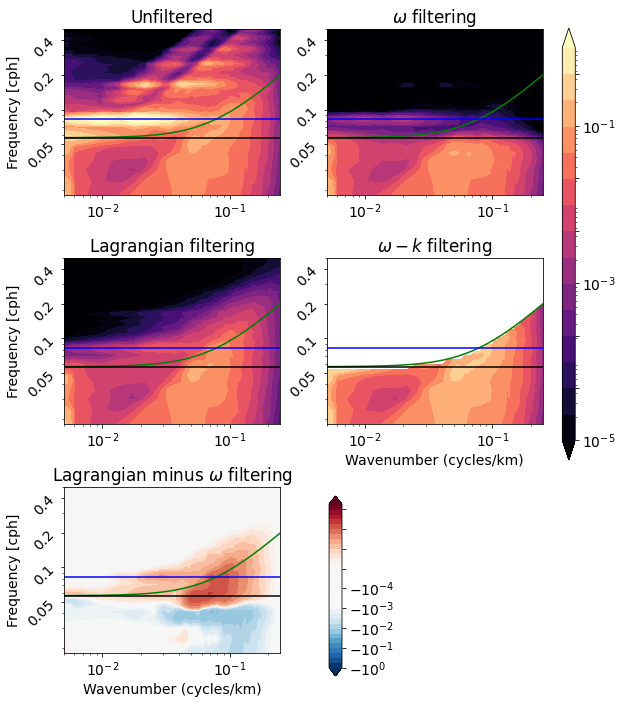

In [25]:
yticks_s = [5*10**-2,10**-1,2*10**-1,4*10**-1]
lev_exp = np.linspace(-5,0,16)
lev = np.power(10, lev_exp)
omega = ps_isoa.freq_time*3600

#lev_exp = np.linspace(-5,-2,16)
#lev = np.power(10, lev_exp)

plt.figure(figsize=(9,10))
plt.subplot(321)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_unfilta,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)


#plt.plot(kr, omegaM[:,5]/np.pi/2, label=i,color='g')
plt.plot(kr, omegaM[:,10]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.018, 0.5])
plt.ylabel('Frequency [cph]')
#plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Unfiltered')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(322)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_eula,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)


#plt.plot(kr, omegaM[:,5]/np.pi/2, label=i,color='g')
plt.plot(kr, omegaM[:,10]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.018, 0.5])
#plt.ylabel('Frequency [cph]')
#plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('$\omega$ filtering')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)


plt.subplot(323)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_isoa,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)


#plt.plot(kr, omegaM[:,5]/np.pi/2, label=i,color='g')
plt.plot(kr, omegaM[:,10]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.018, 0.5])
plt.ylabel('Frequency [cph]')
#plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Lagrangian filtering')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(324)
cs = plt.contourf(kr,omega,np.abs(omega).drop_vars('freq_time')*kr*ps_iso_torresa,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)


#plt.plot(kr, omegaM[:,5]/np.pi/2, label=i,color='g')
plt.plot(kr, omegaM[:,10]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.018, 0.5])
plt.ylabel('')
plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('$\omega-k$ filtering')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(325)
from matplotlib import ticker, colors
lev_exp = np.linspace(-4,0,17)
lev = np.concatenate([-np.power(10, lev_exp)[-1::-1], np.power(10, lev_exp)])
cs2 = plt.contourf(kr,omega,np.abs(omega)*kr*(ps_isoa-ps_iso_eula),lev,norm=colors.SymLogNorm(linthresh=10**-3, linscale=10**-3,
                                              vmin=-1.0, vmax=1.0),cmap='RdBu_r',extend='both')


#plt.plot(kr, omegaM[:,5]/np.pi/2, label=i,color='g')
plt.plot(kr, omegaM[:,10]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.018, 0.5])
plt.ylabel('Frequency [cph]')
plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Lagrangian minus $\omega$ filtering')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.35, 0.02, 0.6])
fig.colorbar(cs, cax=cbar_ax)

cbar_ax = fig.add_axes([0.52, 0.05, 0.02, 0.25])
fig.colorbar(cs2, cax=cbar_ax)

fig.savefig('fwn_all_methods_region_A.png')

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:11: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:31: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:52: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:72: UserWarning: Log scale: values of z <= 0 have been masked
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:96: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.


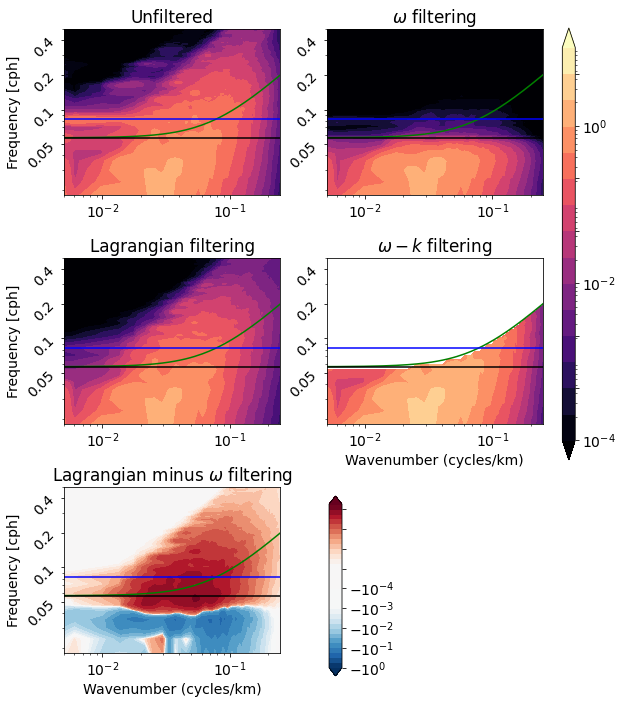

In [26]:
yticks_s = [5*10**-2,10**-1,2*10**-1,4*10**-1]
#lev_exp = np.linspace(-5,0,16)
#lev = np.power(10, lev_exp)
omega = ps_isob.freq_time*3600

lev_exp = np.linspace(-4,1,16)
lev = np.power(10, lev_exp)

plt.figure(figsize=(9,10))
plt.subplot(321)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_unfiltb,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)


#plt.plot(kr, omegaM[:,5]/np.pi/2, label=i,color='g')
plt.plot(kr, omegaM[:,10]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.018, 0.5])
plt.ylabel('Frequency [cph]')
#plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Unfiltered')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(322)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_iso_eulb,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)


#plt.plot(kr, omegaM[:,5]/np.pi/2, label=i,color='g')
plt.plot(kr, omegaM[:,10]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.018, 0.5])
#plt.ylabel('Frequency [cph]')
#plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('$\omega$ filtering')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)


plt.subplot(323)
cs = plt.contourf(kr,omega,np.abs(omega)*kr*ps_isob,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)


#plt.plot(kr, omegaM[:,5]/np.pi/2, label=i,color='g')
plt.plot(kr, omegaM[:,10]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.018, 0.5])
plt.ylabel('Frequency [cph]')
#plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Lagrangian filtering')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(324)
cs = plt.contourf(kr,omega,np.abs(omega).drop_vars('freq_time')*kr*ps_iso_torresb,lev,norm=LogNorm(), cmap='magma',extend='both')
#plt.colorbar(cs)


#plt.plot(kr, omegaM[:,5]/np.pi/2, label=i,color='g')
plt.plot(kr, omegaM[:,10]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.018, 0.5])
plt.ylabel('')
plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('$\omega-k$ filtering')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

plt.subplot(325)
from matplotlib import ticker, colors
lev_exp = np.linspace(-4,0,17)
lev = np.concatenate([-np.power(10, lev_exp)[-1::-1], np.power(10, lev_exp)])
cs2 = plt.contourf(kr,omega,np.abs(omega)*kr*(ps_isob-ps_iso_eulb),lev,norm=colors.SymLogNorm(linthresh=10**-3, linscale=10**-3,
                                              vmin=-1.0, vmax=1.0),cmap='RdBu_r',extend='both')


#plt.plot(kr, omegaM[:,5]/np.pi/2, label=i,color='g')
plt.plot(kr, omegaM[:,10]/np.pi/2, label=i,color='g')
#plt.plot(ps_iso.kr.values, omega_disp.values,'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.018, 0.5])
plt.ylabel('Frequency [cph]')
plt.xlabel('Wavenumber (cycles/km)')
plt.tight_layout()
plt.title('Lagrangian minus $\omega$ filtering')
plt.axhline(-fm/np.pi/2*3600,color='k')
plt.axhline([2/86400*3600],label='Semi-diurnal',color='b')
plt.yticks(yticks_s,yticks_s,rotation=45)

fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.35, 0.02, 0.6])
fig.colorbar(cs, cax=cbar_ax)

cbar_ax = fig.add_axes([0.52, 0.05, 0.02, 0.25])
fig.colorbar(cs2, cax=cbar_ax)

fig.savefig('fwn_all_methods_region_B.png')

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/ipykernel/__main__.py:2: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  from ipykernel import kernelapp as app


(0.018, 0.5)

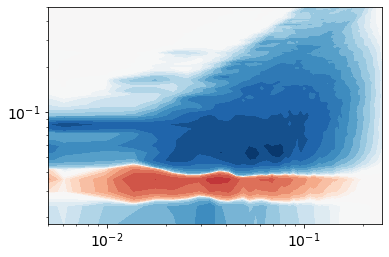

In [27]:
cs2 = plt.contourf(kr,omega,np.abs(omega)*kr*(ps_iso_eulb-ps_iso_unfiltb),lev,norm=colors.SymLogNorm(linthresh=10**-3, linscale=10**-3,
                                              vmin=-1.0, vmax=1.0),cmap='RdBu_r',extend='both')
plt.xscale('log')
plt.yscale('log')
plt.xlim([0.005, 0.25])
plt.ylim([0.018, 0.5])

In [28]:
ps_iso_eulb

<xarray.DataArray (freq_time: 168, kr: 129)>
array([[           nan, 4.12157708e-08, 5.16227826e-09, ...,
        5.49959732e-08, 5.35337103e-08, 9.36724775e-09],
       [           nan, 1.56771573e-07, 9.26248902e-09, ...,
        7.16287058e-08, 6.85679506e-08, 1.17295343e-08],
       [           nan, 4.11651888e-07, 9.57042132e-09, ...,
        5.60775118e-08, 5.32871221e-08, 9.70060184e-09],
       ...,
       [           nan, 4.04540492e-07, 2.05929415e-08, ...,
        5.93775850e-08, 5.70953135e-08, 1.10095081e-08],
       [           nan, 4.11651888e-07, 9.57042132e-09, ...,
        5.60775118e-08, 5.32871221e-08, 9.70060184e-09],
       [           nan, 1.56771573e-07, 9.26248902e-09, ...,
        7.16287058e-08, 6.85679506e-08, 1.17295343e-08]])
Coordinates:
  * freq_time  (freq_time) float64 -0.0001389 -0.0001372 ... 0.0001356 0.0001372
  * kr         (kr) float64 0.0 0.002653 0.006041 ... 0.4921 0.496 0.5611